In [22]:
import importlib
import numpy as np
import graph_analysis_functions as gaf
import pickle
importlib.reload(gaf)

<module 'graph_analysis_functions' from '/home/admin/Ana/MicroBrain/codes/Graph Analysis & by region/graph_analysis_functions.py'>

In [23]:
EDGE_NKIND_TO_LABEL = {
    2: "arteriole",
    3: "venule",
    4: "capillary"
}


In [24]:
path = "/home/admin/Ana/MicroBrain/output/graph_18_OutGeom_Hcut3.pkl"
res = np.array([1.625, 1.625, 2.5])
center = np.array([2100, 4200, 750])   # voxels
box_um = np.array([400, 400, 400])     # µm

box = gaf.make_box(center, box_um, res)

data = pickle.load(open(path, "rb"))

# Before any analysis, comply attributes:
gaf.sync_vertex_attributes(data)

G = data["graph"]

[make_box] size check (µm): x=400.00, y=400.00, z=400.00


In [25]:

# Checks if the graph is a single component. If not, saves the graph as the biggest connected component. 
_,_, G = gaf.single_connected_component(G)


# First, graph sanity check 
ed = gaf.duplicated_edge_stats(G)
loops = gaf.loop_edge_stats(G)
ed, loops

The graph has 6 components. Keeping the largest one.


({'n_pairs_duplicated': 8,
  'n_extra_edges': 8,
  'perc_extra_edges': 0.8771929824561403},
 {'n_loops': 0, 'perc_loops': 0.0, 'loop_indices': []})


Edge types:

 - arteriole (nkind=2): 72 edges (7.9%)
 - capillary (nkind=4): 840 edges (92.1%)

Average diameter by nkind:

nkind = 2: average diameter = 9.424842 µm
nkind = 4: average diameter = 6.933814 µm


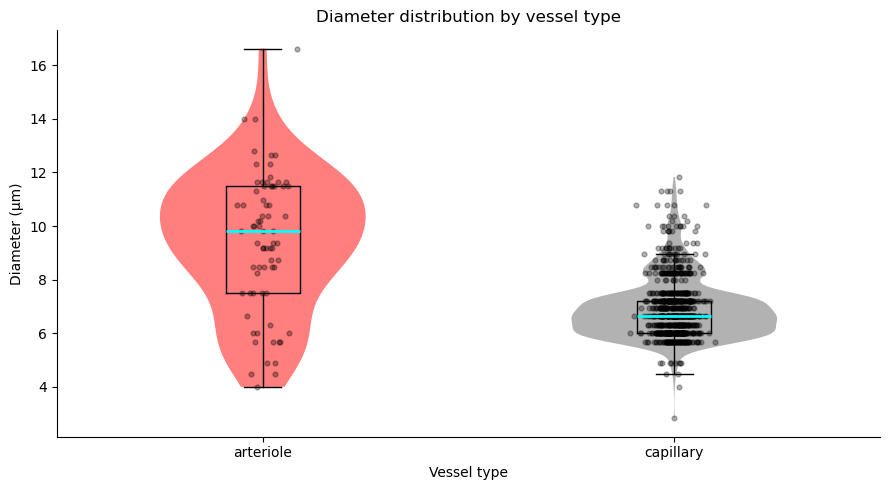


Average length by nkind:

nkind = 2: average length (att) = 25.324381 µm
nkind = 4: average length (att) = 26.404158 µm
Unique degrees: [1 2 3 4 5 6]
HDN (>= 4): 37

=== HDN fingerprint (deg ≥ 4) ===
HDN: 37 / 792  (4.67%)

HDN node-type composition (inferred from incident edge nkind):
  capillary :   33  (89.2%)
  arteriole :    4  (10.8%)

HDN depth (distance_to_surface) µm: median=62.91, mean=62.35, min=43.60, max=75.00
Depth bins:
     0–20:    0 (0.0%)
    20–50:    4 (10.8%)
   50–200:   33 (89.2%)
     >200:    0 (0.0%)

Spatial concentration ratio (HDN/all) = 0.816  (<1 => HDN more concentrated)

=== HDN fingerprint (deg ≥ 4) ===
HDN: 37 / 792  (4.67%)

HDN node-type composition (inferred from incident edge nkind):
  capillary :   33  (89.2%)
  arteriole :    4  (10.8%)

HDN depth (distance_to_surface) µm: median=62.91, mean=62.35, min=43.60, max=75.00
Depth bins:
     0–20:    0 (0.0%)
    20–50:    4 (10.8%)
   50–200:   33 (89.2%)
     >200:    0 (0.0%)

Face bias (fraction

{'degree_thr': 4,
 'n_nodes': 792,
 'n_hdn': 37,
 'hdn_fraction': 0.04671717171717172,
 'spatial': {'centroid_all': [2099.2216785701444,
   4187.053538429937,
   739.4948036118604],
  'centroid_hdn': [2057.801959063556, 4178.980970228041, 731.6472877296242],
  'centroid_shift': [-41.419719506588535,
   -8.072568201896502,
   -7.84751588223628],
  'mean_dist_to_centroid_all': 118.58254146539961,
  'mean_dist_to_centroid_hdn': 96.77002697005608,
  'concentration_ratio_hdn_over_all': 0.8160562741716236},
 'hdn_type_composition': {'arteriole': {'count': 4,
   'proportion': 0.10810810810810811},
  'capillary': {'count': 33, 'proportion': 0.8918918918918919}},
 'depth_hdn': {'n': 37,
  'min': 43.60332465171814,
  'mean': 62.354424102886306,
  'median': 62.91499948501587,
  'max': 74.99687671661377,
  'bins': {'0–20': {'range_um': [0.0, 20.0], 'count': 0, 'proportion': 0.0},
   '20–50': {'range_um': [20.0, 50.0],
    'count': 4,
    'proportion': 0.10810810810810811},
   '50–200': {'range_um'

In [26]:
# Nkinds 
unique, counts = gaf.get_edges_types(G)

unique, mean_diameter = gaf.get_avg_diameter_nkind(G)

stats = gaf.diameter_stats_nkind(G)

avg_length = gaf.get_avg_length_nkind(G)

unique_deg, hdn_idx = gaf.get_degrees(G, threshold=4)

gaf.analyze_hdn_pattern_in_box(G)

gaf.distance_to_surface_stats(G, hdn_idx)


gaf.analyze_hdn_pattern_in_box(
    G,
    degree_thr=4,
    box=box,  # si estás en ROI; si no, pon None
    coords_attr="coords_image",
    depth_attr="distance_to_surface",
)

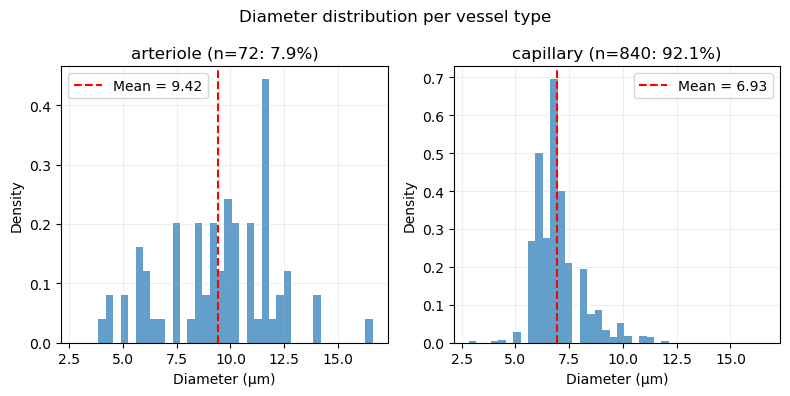

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'arteriole (n=72: 7.9%)'}, xlabel='Diameter (µm)', ylabel='Density'>,
        <Axes: title={'center': 'capillary (n=840: 92.1%)'}, xlabel='Diameter (µm)', ylabel='Density'>],
       dtype=object))

In [27]:
gr = G.es["diameter"]
n = G.es["nkind"]

gaf.plot_hist_by_category_general(gr, n, label_dict = EDGE_NKIND_TO_LABEL,
    variable_name="Diameter (µm)",
    main_title="Diameter distribution per vessel type")

BC ANALYSIS

In [28]:
#Note: Faces are directly computed in the loop

bc_results = gaf.analyze_bc_faces(
    G,
    box=box,
    coords_attr="coords_image",
    eps=2.0,
    degree_thr=4,
    compute_types=True,
    compute_depth=True,
    return_node_ids=False,
    verbose=True
)



=== BC ANALYSIS (PER FACE) ===
Graph: 792 vertices, 912 edges
coords_attr='coords_image' | eps=2.0 | degree_thr=4

--- x_min ---
BC nodes: 44
Degree (d:count): 1:40, 3:3, 4:1
High-degree (>= 4): 1 (2.27%)
  capillary: 39 (88.6%)
  arteriole: 5 (11.4%)
distance_to_surface (µm): min=41.53, mean=61.15, median=61.96, max=75.30

--- x_max ---
BC nodes: 50
Degree (d:count): 1:46, 3:3, 5:1
High-degree (>= 4): 1 (2.00%)
  capillary: 49 (98.0%)
  arteriole: 1 (2.0%)
distance_to_surface (µm): min=41.53, mean=61.15, median=61.96, max=75.30

--- y_min ---
BC nodes: 69
Degree (d:count): 1:64, 3:5
High-degree (>= 4): 0 (0.00%)
  capillary: 65 (94.2%)
  arteriole: 4 (5.8%)
distance_to_surface (µm): min=41.53, mean=61.15, median=61.96, max=75.30

--- y_max ---
BC nodes: 40
Degree (d:count): 1:36, 3:3, 4:1
High-degree (>= 4): 1 (2.50%)
  capillary: 39 (97.5%)
  arteriole: 1 (2.5%)
distance_to_surface (µm): min=41.53, mean=61.15, median=61.96, max=75.30

--- z_min ---
BC nodes: 73
Degree (d:count): 1:5

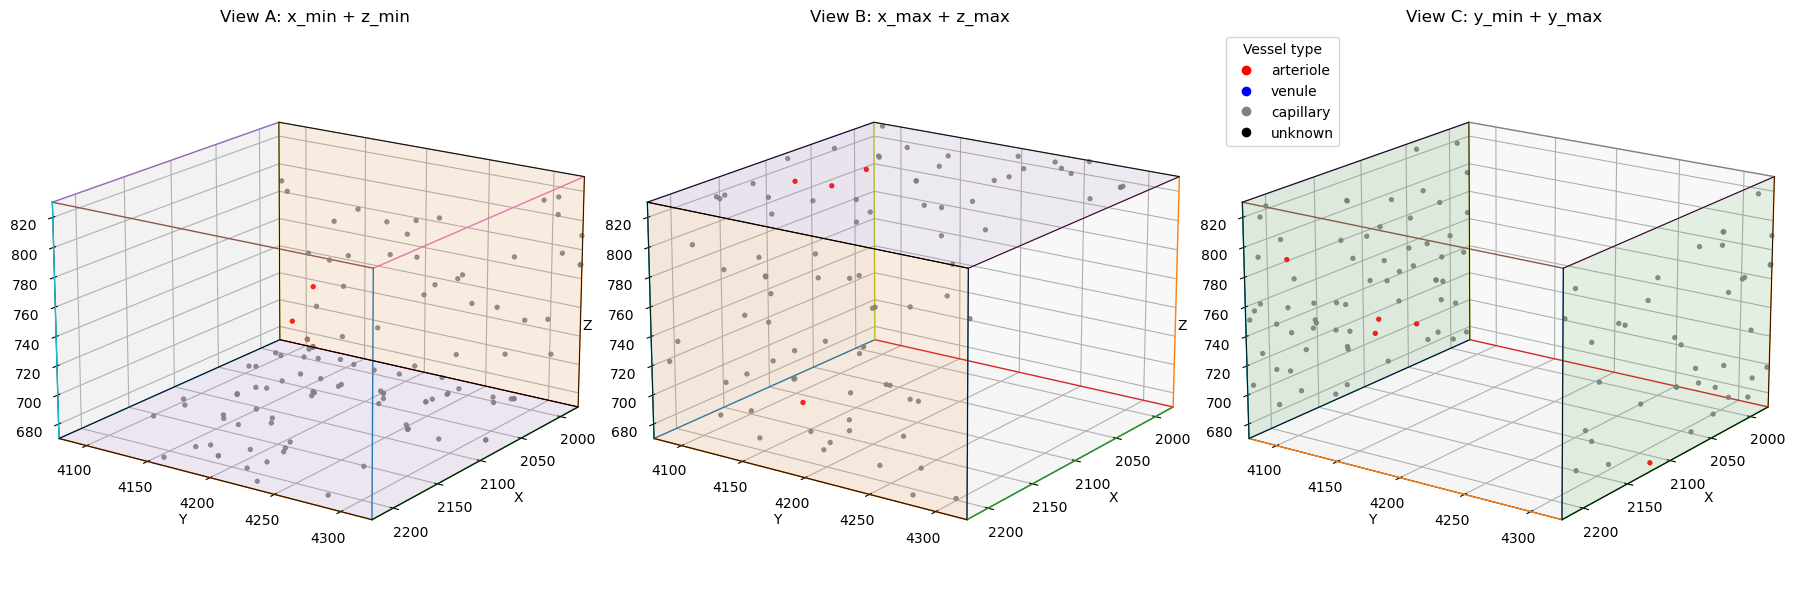

In [29]:
gaf.plot_bc_3_cubes_tinted(G, box)

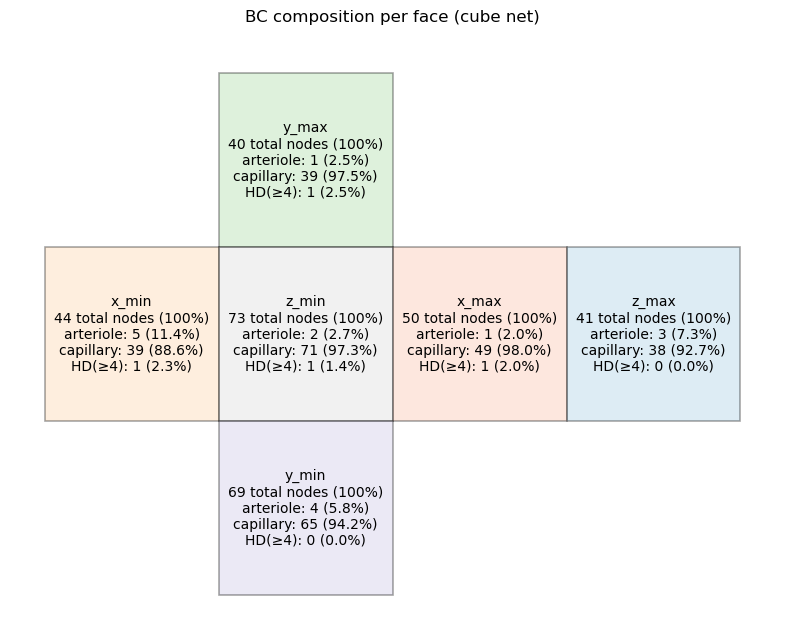

In [30]:
gaf.plot_bc_cube_net(bc_results)

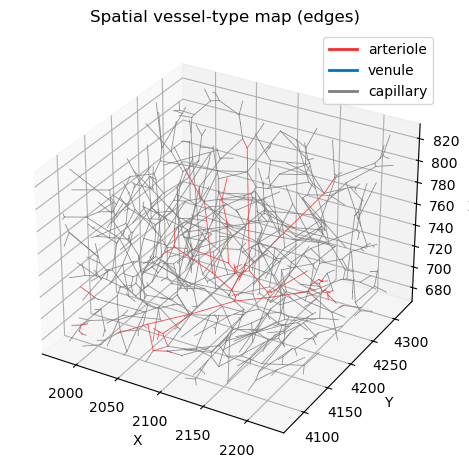

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'Spatial vessel-type map (edges)'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [31]:
gaf.plot_nkind_spatial_edges(G)

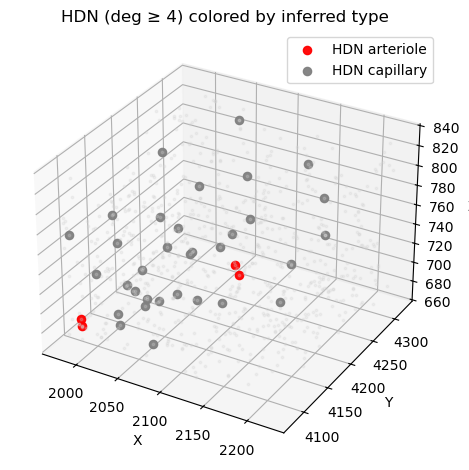

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'HDN (deg ≥ 4) colored by inferred type'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [32]:
gaf.plot_high_degree_nodes_by_type(G)


In [33]:
gaf.bc_faces_table(bc_results)

,Box,Face,BC nodes,% Arteriole,% Venule,% Capillary,% Unknown,High degree %
0,Box,x_min,44,11.363636,0.0,88.636364,0.0,2.272727
1,Box,x_max,50,2.000000,0.0,98.000000,0.0,2.000000
2,Box,y_min,69,5.797101,0.0,94.202899,0.0,0.000000
3,Box,y_max,40,2.500000,0.0,97.500000,0.0,2.500000
4,Box,z_min,73,2.739726,0.0,97.260274,0.0,1.369863
5,Box,z_max,41,7.317073,0.0,92.682927,0.0,0.000000
